In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from random import randint

import numpy as np

# I. Check data

데이터 확인 - 훈련(2800이미지)데이터, 테스트(400이미지)데이터로 구분되어 있음.

훈련셋의 각 클래스에는 27-47개의 이미지가 포함되어 있으며, 테스트 셋의 경우 4-6개 이미지가 포함, 레이블은 87개

87 classes with 3219 images in total


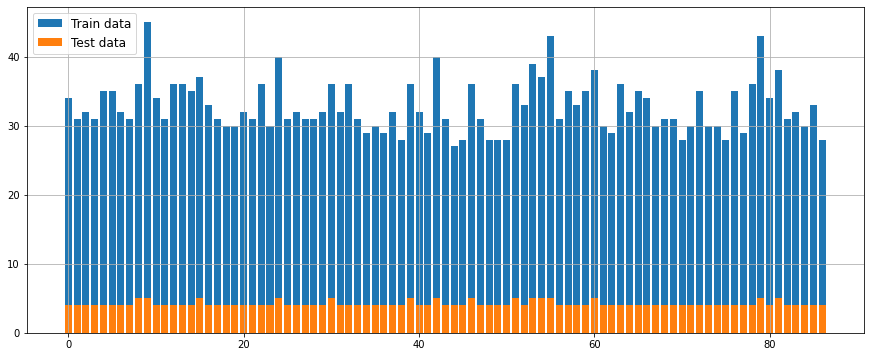

In [2]:
CLASSES, gems = [], [] # names of classes, count of images for each class

for root, dirs, files in os.walk('./archive'):
    f = os.path.basename(root)    # get class name - Amethyst, Onyx, etc    
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) # add folder name
            
gems_count = len(CLASSES) # 87 = number of classes
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

f, ax = plt.subplots(figsize=(15,6))
if(gems[0])<10:
    plt.bar(range(gems_count), gems[gems_count:], label = 'Train data')
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Test data')
else:
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Train data')
    plt.bar(range(gems_count), gems[gems_count:], label = 'Test data')
ax.grid()
ax.legend(fontsize = 12);

# II. Prepare training data
## 1. Prepare parameters
parameters : 처리된 이미지의 크기를 img_w, img_h로 조정 - this option will be used when cropped and as a parameter of neural network;

In [3]:
img_w, img_h = 220, 220    # width and height of image
train_dir = './archive/train/'

## 2. 이미지와 클래스 이름 읽는 함수 생성
- cv2를 사용하여 디스크에서 각 이미지를 읽고 img_w*1.5, img_h*1.5로 크기를 조정
- opencv는 RGB 색상 형식 대신 BGR 색상 형식으로 이미지를 읽고 표시하므로 COLOR_BGR2RGB 옵션임
- 이 옵션이 없으면 매트 플롯 lib가 RGB를 사용하여 이미지를 표시하므로 영상이 파란색으로 표시됨
- 폴더를 읽는 동안 클래스 이름 목록 작성(Amethyst, Onyx 등)
- 이미지 목록이 준비되면 Numpy 배열로 변환합니다


In [4]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)  # get class name - Amethyst, Onyx, etc       
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)              # read the image (OpenCV)
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))       # resize the image (images are different sizes)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converts an image from BGR color space to RGB
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

## 3. 문자열 라벨을 숫자로 변환하는 함수 생성
-  클래스 목록을 사용하여 문자열 레이블을 숫자 목록으로 변환
- 인덱스는 클래스 라벨(F.e.Ruby = 0, Amethyst st 24 등)을 나타냄
- 라벨 목록이 준비되면 -> Numpy 배열로 변환


In [5]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):    # foreach CLASSES
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

## 4. 이미지 배열과 해당 레이블을 데이터로 채우기
- 각각 원석 클래스의 이미지와 해당 이름을 포함하는 두 개의 배열 Train_Imgs, Train_Lbls를 생성
- 문자열이 있는 Train_Lbls를 해당 번호로 목록으로 변환
- 사진을 저장하는 Train_Imgs는 4차원임. 이미지 수 x 이미지 너비 x 이미지 높이 x 이미지 채널


In [6]:
Train_Imgs, Train_Lbls = read_imgs_lbls(train_dir)
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))

Shape of train images: (2856, 330, 330, 3)
Shape of train labels: (2856,)


## 5. preview를 위해 이미지 및 레이블 plot
	-> 그림이 대부분 가운데에 있음


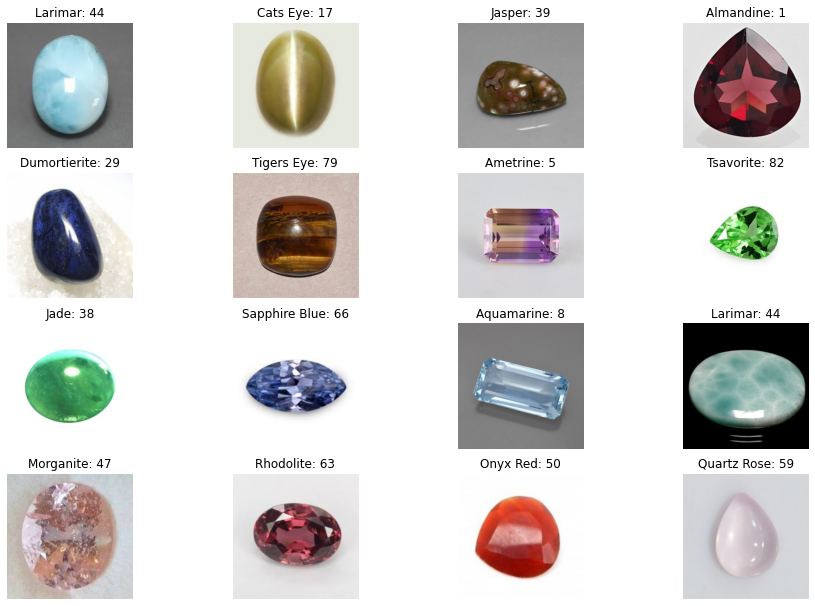

In [7]:
dim = 4 #you can change it;  4x4 dimension flat plot

f,ax = plt.subplots(dim,dim) 
f.subplots_adjust(0,0,2,2)
for i in range(0,dim):
    for j in range(0,dim):
        rnd_number = randint(0,len(Train_Imgs))
        cl = Train_Lbls[rnd_number]
        ax[i,j].imshow(Train_Imgs[rnd_number])
        ax[i,j].set_title(CLASSES[cl]+': ' + str(cl))
        ax[i,j].axis('off')

## Canny 알고리즘을 사용하여 이미지의 가장자리를 자름

-> Canny알고리즘: 이미지에 있는 개체의 가장자리를 감지하는 알고리즘
- edge_and_cut(img) 함수는 이미지를 받아 img_w, img_h 크기의 잘린 이미지(new_img)를 반환

- 간혹 캐니는 가장자리(예: 객체가 배경과 거의 동일한 색을 가질 때)를 감지하지 못하므로 배열 가장자리가 0 값이 됨. 이 경우 원본 이미지를 사용.


In [8]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           # crop the region
            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert back
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

## 6. 잘린 이미지 표시
- Canny alogo의 작동 방식을 더 잘 이해하기 위해
- 원본 이미지, Canny edge, 경계 box가 있는 이미지, 잘라낸 이미지 표시

In [9]:
def show_cropped(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
            
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)

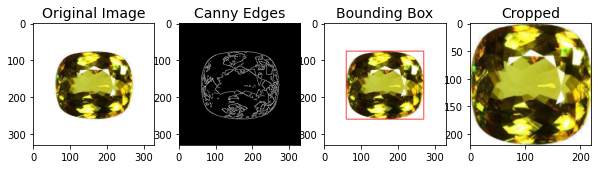

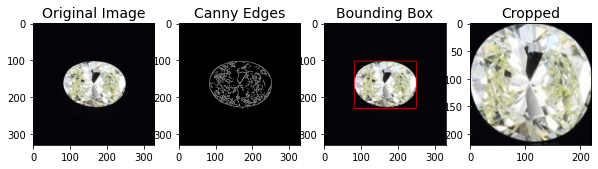

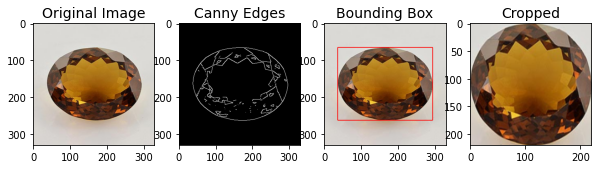

In [10]:
for x in range(0,3):
    show_cropped(Train_Imgs[randint(0,len(Train_Imgs))])

## 7. Replace train images with cropped images
- edge_and_cut를 호출하고 Train_Imgsnumpy 배열을 잘라낸 이미지 배열로 대체하는 함수를 생성 (잘라낼 수 없는 이미지는 원본으로 대체)
- 최종 배열의 모양이 동일한지 확인. NUMBER OF IMAGES ximg_w ximg_h x 3(채널):


In [11]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [12]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

Final shape of images in train set: (2856, 220, 220, 3) 


## 8. Split data into train and validation sets

- use sklearn to split Train_Imgs, Train_Lbls into train (80%) and validation (20%) sets. Important!

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (2284, 220, 220, 3), y_train: (2284,) 
Shape of X_val: (572, 220, 220, 3), y_val: (572,) 


# III. Prepare for model creation

## 1. Check devices

#### 텐서 플로우를 사용하여 어떤 장치가 Kaggle 플랫폼을 사용하는지 확인한다.

- XLA_CPU 디바이스: CPU
- XLA_GPU 장치: Tesla P100-PCie-16GB(컴퓨팅을 가속화하려면 GPU 모드를 사용합니다.)
#### XLA는 가속 선형 대수를 나타냅니다. Tensorflow의 비교적 최적화된 컴파일러로 ML 모델의 속도를 더욱 높일 수 있습니다.

#### GPU 모드를 사용하여 이 노트북을 실행합니다 : 
for example, using image size 190 x 190 and basic architecture of CNN

mentioned above every epoch on CPU takes ~3 minutes, on GPU ~ 15 sec.

In [14]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15201461289306292691
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4922553139
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9295483529246702429
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [15]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Import keras
Keras is an open-source neural-network library written in Python which is capable of running on top of TensorFlow. From Keras needed:

- models : type of models, import only Sequential
- layers : 모델에 해당하는 레이어: 단순한 레이어는 Conv2D, MaxPooling2D 및 AveragePooling2D만 사용
- optimizers : 역전파 알고리즘 포함
- ImageDataGenerator : 이미지 증강용(각 클래스의 샘플이 그리 많지 않을때)


In [16]:
from tensorflow import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers


In [17]:
# test harness for evaluating models on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# Build a simple CNN
CNN(Convolutional Neural Network 또는 ConvNet)은 시각 이미지 분석에 일반적으로 적용되는 심층 신경 네트워크의 한 종류이다. 다음은 CNN의 가장 간단한 예이다.

# I. Provide Hyperparameters
하이퍼 파라미터는 훈련 전에 설정된다. neural network 구조와 훈련 방법을 결정하는 변수를 나타낸다.

## 1. Parameters for layers
- 컨볼루션 레이어 필터 크기(필터). 필터 수는 데이터 세트의 복잡성과 신경 네트워크의 깊이에 따라 달라져야 한다.
- 세 개의 레이어에 대한 공통 설정은 [32, 64, 128].
- kernel_size = number of filters 전체 이미지가 스캔될 때 한번에 이동하는 픽셀 창(3 X 3)
- 만약 이미지가 128×128보다 작으면 1×1의 작은 필터로 작업.
- 이미지의 폭과 높이는 미리 제공됨. 2D 컨볼루션 레이어는 3차원 입력(일반적으로 3개의 컬러 채널이 있는 이미지)을 취함.
- max_pool = max pooling은 2D 입력 공간에 걸쳐 움직이는 창을 적용한 것으로, 이 창에서 최대값은 출력 2x2.


In [18]:
filters = 32      # the dimensionality of the output space
kernel_size = 3   # length of the 2D convolution window
max_pool = 2      # size of the max pooling windows

## 2. Parameters to fit the model

- epoch는 알고리즘이 전체 데이터 집합을 보는 횟수를 나타냄. 데이터 집합의 모든 샘플을 알고리즘에서 볼 때마다 하나의 에포크가 완료됨
- 한 에포크가 완료되는 것은 너무 커서 한 번에 메모리에 전달할 수 없기 때문에 그것을 몇 개의 작은 배치로 나눔. 배치 크기는 항상 2의 배율
- 에포크당 반복 횟수 = 패스 수, 각 패스는 배치 크기를 사용.

따라서 교육 샘플이 최대 2,200(80%)이고 배치 크기가 32인 경우 1개 에포크를 완료하는 데 70회까지 반복해야 함

In [22]:
EPOCHS = 70                                 # while testing you can change it
batch_size = 32                              # number of training samples using in each mini batch during GD (gradient descent) 
iter_per_epoch = len(X_train) // batch_size  # each sample will be passed [iter_per_epoch] times during training
val_per_epoch = len(X_val) // batch_size     # each sample will be passed [val_per_epoch] times during validation

# Provide a model
## 1. Architect a model
순차 모델은 레이어의 선형 스택입니다.
- I use a kind of VGG network architecture:
Layers
1	Conv2D 32 -> Pool
2	Conv2D 64 -> Pool
3	Conv2D 128 -> Pool
4	Conv2D 128 -> Pool
5	Conv2D 128 -> Pool
6	FLAT
7	Drop
8	Dense 512
9	Dense len(CLASSES)

#### ADD 5 'blocks':
- 위에 언급된 하이퍼마미터가 있는 Conv2D: Conv2D(커널_size, (filters, filters), input_shape=(img_w, img_h, 3)) 및 각 레이어에 대한 활성화 함수(ReLU): 활성화('relu')
- 들어오는 특성의 공간 크기를 줄이기 위한 MaxPooling 2D 레이어, 2D input space: MaxPooling 2D(pool_size =(max_pool, max_pool)
- 커널 크기를 32 -> 64 -> 128 -> 128 -> 128로 늘리기 위해 동일한 작업을 수행.
#### 2. 입력을 지연. 다차원 벡터를 단일 차원 벡터로 변환: Flatten()
#### 3. 입력의 특정 부분을 임의로 0으로 설정하고 과적합을 줄이는 데 도움이 되는 드롭아웃 계층 추가: Dropout(0.5)
#### 4. 512개 노드로 완전 연결된 레이어 추가 및 활성화 함수 relu: ense(512), Activation('relu')
#### 5. 원석의 클래스 수를 지정하는 마지막 완전히 연결된 레이어를 제공: 87. 소프트맥스 활성화 함수는 잠재적 결과 목록의 확률 분포를 나타내는 벡터를 출력: Dense(87, activation='softmax')
</br>
- Print the summary of the model.

In [33]:
from keras.layers import BatchNormalization
model = Sequential()

# first layer
model.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(img_w, img_h, 3))) # 32
model.add(BatchNormalization())
model.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((max_pool, max_pool))) #reduce the spatial size of incoming features
model.add(Dropout(0.2))
# second layer
model.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 64
model.add(BatchNormalization())
model.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 64
model.add(BatchNormalization())
model.add(MaxPooling2D((max_pool, max_pool))) 
model.add(Dropout(0.3))
# third layer
# model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
# model.add(BatchNormalization())
# model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
# model.add(BatchNormalization())
# model.add(MaxPooling2D((max_pool, max_pool))) 
# model.add(Dropout(0.4))
# # fourth layer
# model.add(Conv2D(8*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
# model.add(BatchNormalization(axis=3))
# model.add(MaxPooling2D((max_pool, max_pool))) 

# #fifth layer
# model.add(Conv2D(16*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
# model.add(BatchNormalization(axis=3))
# model.add(MaxPooling2D((max_pool, max_pool))) 

model.add(Flatten())
model.add(Dense(4*batch_size, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(87, activation='softmax'))
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 220, 220, 32)      896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 220, 220, 32)      128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 110, 110, 64)     

모델 요약에는 교육해야 할 매개 변수가 2M 이상이고 서로 다른 계층에 대한 정보가 있음을 보여 줍니다.

## Compile a model

- 확률 적 경사 하강 법 (SGD) 알고리즘의 일반화 인 아담 옵티 마이저를 사용하여 모델을 컴파일. 제공되는 손실 함수는 다중 클래스 분류를 수행하므로 sparse_categorical_crossentropy


In [34]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# III. Fit the train generator

## 1. Image augmentation
> Image augmentation is a creation of additional training data based on existing images, for example translation, rotation, flips and zoom

- 각 클래스에 대해 샘플이 그리 많지 않은 한 증강 파라미터가 있는 클래스 Image Data Generator를 사용하여 훈련 데이터 생성기를 추가합니다. Keras 라이브러리의 ImageDataGenerator 클래스를 사용하여 메모리에 각 원석 클래스의 추가 이미지를 만듦


In [35]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(              # this is the augmentation configuration used for training
        rotation_range=25,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True
        )

val_datagen = ImageDataGenerator()                # for val/testing only rescaling function 

- the original image + examples of work of ImageDataGenerator:

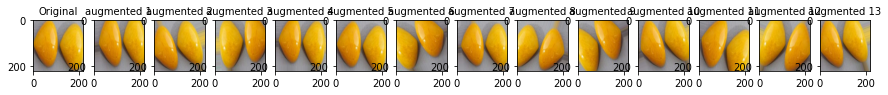

In [36]:
n = randint(0,len(X_train))
samples = np.expand_dims(X_train[n], 0)
it = train_datagen.flow(samples, batch_size=64)
cols = 14

fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(15, 10))
ax[0].imshow(X_train[n], cmap='gray')
ax[0].set_title('Original', fontsize=10)

for i in range(1,cols):
    batch = it.next()    # generate batch of images 
    image = batch[0].astype('uint32') # convert to unsigned int for viewing
    ax[i].set_title('augmented {}'.format(i), fontsize=10)
    ax[i].imshow(image, cmap='gray')

Create two numpy array iterators train_gen and val_gen and fill them with additional images:

In [37]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [38]:
print(len(train_gen))

72


## Fit the model
- get a history object
- val_los 매개 변수가 증가하면 과적합이 됨

In [42]:
m = model.fit_generator(
       train_gen,
       steps_per_epoch= iter_per_epoch,
       epochs=100, 
       validation_data = val_gen,
       validation_steps = val_per_epoch,
       verbose = 1
       )

Epoch 1/100
71/71 [==============================] - 24s 339ms/step - loss: 0.6891 - accuracy: 0.7718 - val_loss: 1.2400 - val_accuracy: 0.6581
Epoch 2/100
71/71 [==============================] - 24s 335ms/step - loss: 0.6633 - accuracy: 0.7833 - val_loss: 1.2080 - val_accuracy: 0.6618
Epoch 3/100
71/71 [==============================] - 24s 335ms/step - loss: 0.6632 - accuracy: 0.7731 - val_loss: 1.2895 - val_accuracy: 0.6158
Epoch 4/100
71/71 [==============================] - 22s 303ms/step - loss: 0.6739 - accuracy: 0.7833 - val_loss: 1.2344 - val_accuracy: 0.6618
Epoch 5/100
71/71 [==============================] - 21s 298ms/step - loss: 0.6073 - accuracy: 0.7948 - val_loss: 1.2648 - val_accuracy: 0.6710
Epoch 6/100
71/71 [==============================] - 26s 362ms/step - loss: 0.6022 - accuracy: 0.7993 - val_loss: 1.2314 - val_accuracy: 0.6434
Epoch 7/100
71/71 [==============================] - 24s 332ms/step - loss: 0.6100 - accuracy: 0.7953 - val_loss: 1.2453 - val_accuracy:

71/71 [==============================] - 23s 329ms/step - loss: 0.4322 - accuracy: 0.8459 - val_loss: 1.3299 - val_accuracy: 0.6562
Epoch 58/100
71/71 [==============================] - 23s 326ms/step - loss: 0.4148 - accuracy: 0.8468 - val_loss: 1.7363 - val_accuracy: 0.6268
Epoch 59/100
71/71 [==============================] - 24s 336ms/step - loss: 0.4287 - accuracy: 0.8557 - val_loss: 1.3436 - val_accuracy: 0.6857
Epoch 60/100
71/71 [==============================] - 24s 331ms/step - loss: 0.4274 - accuracy: 0.8557 - val_loss: 1.3615 - val_accuracy: 0.6636
Epoch 61/100
71/71 [==============================] - 24s 331ms/step - loss: 0.4525 - accuracy: 0.8490 - val_loss: 1.3293 - val_accuracy: 0.6875
Epoch 62/100
71/71 [==============================] - 24s 330ms/step - loss: 0.4591 - accuracy: 0.8517 - val_loss: 1.3203 - val_accuracy: 0.6930
Epoch 63/100
71/71 [==============================] - 24s 334ms/step - loss: 0.4052 - accuracy: 0.8632 - val_loss: 1.2970 - val_accuracy: 0.680

## Check the accuracy
- plot the accuracy of model against size of epoch (train and val);
- plot the loss of model against size of epoch (train and val).

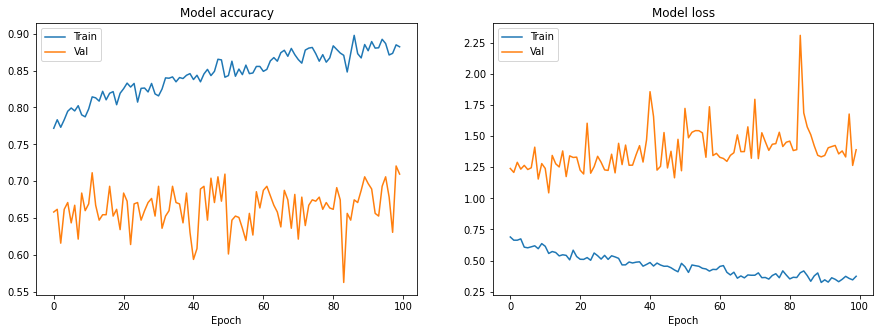

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].plot(m.history['accuracy'])
axs[0].plot(m.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].legend(['Train', 'Val'], loc='upper left')

axs[1].plot(m.history['loss'])
axs[1].plot(m.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].legend(['Train', 'Val'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')

there is an overfitting: even though train and val accuracy are pretty close to each other, val_loss parameter often 'jumps'.

## Score the model

> Accuracy is a metric for evaluating classification models. Accuracy  = Number of right predictions / Total number of predictions.

- 함수 account_generator는 데이터 생성기에서 모델을 평가합니다. 점수는 스칼라 목록(손실 및 정확도)입니다.

In [45]:
score = model.evaluate_generator(val_gen, steps= len(val_gen))

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

loss:1.4369630813598633
accuracy:0.6958041787147522


## Confusion matrix

- from sklearn.metrics import confusion_matrix: Diagonal of matrix should be mostly filled with numbers.

In [ ]:
from sklearn.metrics import confusion_matrix
y_pre_test=model.predict(X_val)
y_pre_test=np.argmax(y_pre_test,axis=1)
cm=confusion_matrix(y_val,y_pre_test)

plt.figure(figsize = (15,15))
sn.heatmap(cm, annot=True)

많은 양의 클래스가 있기 때문에 모델별로 잘못 분류된 원석을 표시합니다.

numpy.argmaxismunction은 배열 내부의 특정 축을 따라 최대 원소의 indices를 반환합니다(axis = 1 - 'horizontally').

- 검증 세트 X_val로 대체될 잘못 분류된 인덱스 목록을 생성합니다.
- 잘못 분류된 원석을 플롯합니다.

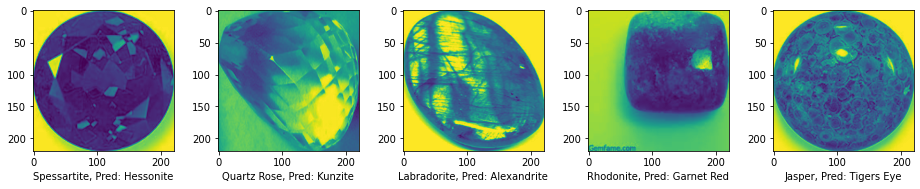

In [29]:
x=(y_pre_test-y_val!=0).tolist()
x=[i for i,l in enumerate(x) if l!=False]

fig,ax=plt.subplots(1,5,sharey=False,figsize=(13,13))
fig.tight_layout()

for i in range(5):
    ax[i].imshow(X_val[x[i]][:,:,1])
    ax[i].set_xlabel('{}, Pred: {}'.format(CLASSES[y_val[x[i]]],CLASSES[y_pre_test[x[i]]]))

Don't judge poor model. Just look at Almandine, Garnet Red, Hessonite, Pyrope and Rhodolite. Can you distinguish between them?

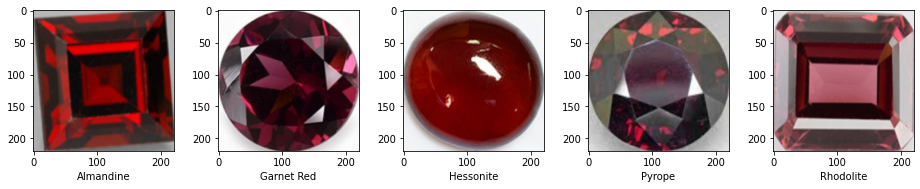

In [30]:
red_stones = ['Almandine', 'Garnet Red', 'Hessonite', 'Pyrope', 'Rhodolite']
red_stones = get_class_index(red_stones)

fig,ax=plt.subplots(1,len(red_stones),sharey=False,figsize=(13,13))
fig.tight_layout()

for i in range(len(red_stones)):
    ax[i].imshow(Train_Imgs[np.where(Train_Lbls==red_stones[i])[0][1]])
    ax[i].set_xlabel(CLASSES[red_stones[i]])

## Save the mode
new_model.load_weights('model_gemstons.h5')를 사용하여 다른 모델에서 재사용할 수 있습니다

In [31]:
model.save('model_gemstones.h5')

# IV. Evaluate on testing folder

In [57]:
test_dir = './archive/test/'

In [58]:
Test_Imgs, Test_Lbls = read_imgs_lbls(test_dir)
Test_Lbls = get_class_index(Test_Lbls)

## Crop test images

In [59]:
Test_Imgs = crop_images(Test_Imgs)
print('shape of images in test set: {} '.format(Test_Imgs.shape))


shape of images in test set: (363, 220, 220, 3) 


C:\Users\dbfgm\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


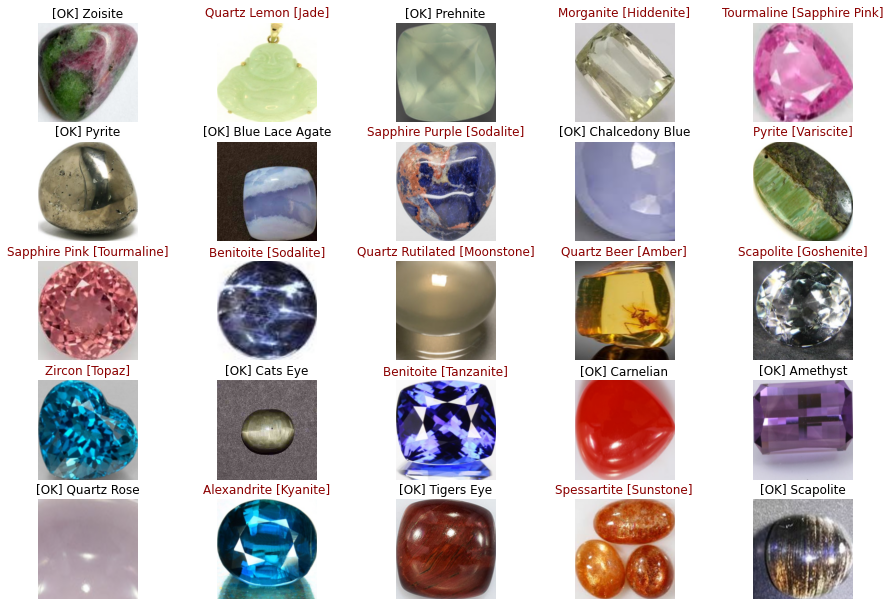

In [60]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,2,2)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Test_Imgs))
        pred_image = np.array([Test_Imgs[rnd_number]])
        pred_class = model.predict_classes(pred_image)[0]
        pred_prob = model.predict(pred_image).reshape(87)
        act = CLASSES[Test_Lbls[rnd_number]]
        ax[i,j].imshow(Test_Imgs[rnd_number])
        ax[i,j].imshow(pred_image[0])
        if(CLASSES[pred_class] != CLASSES[Test_Lbls[rnd_number]]):
            t = '{} [{}]'.format(CLASSES[pred_class], CLASSES[Test_Lbls[rnd_number]])
            ax[i,j].set_title(t, fontdict={'color': 'darkred'})
        else:
            t = '[OK] {}'.format(CLASSES[pred_class]) 
            ax[i,j].set_title(t)
        ax[i,j].axis('off')
